# Analysis for duplessis-2021-SO-thermohaline

#### This notebook is the code used to plot the figures du Plessis et al - JGR Oceans

The code is run in the following order:

## 1. Load some modules and set some parameters

### 1.1 Modules

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm_notebook
import cmocean.cm as cmo
import pandas as pd
import numpy as np
import glidertools as gt
import my_functions as my
import my_plot_params

lightblue = '#5499c7'
blue      = '#21618c'
orange    = '#f39c12'
green     = '#27ae60'
red       = '#cb4335'

import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator(interval=1)  # every month
week = mdates.WeekdayLocator(byweekday=mdates.MO, interval=1)
weeks = mdates.WeekdayLocator(byweekday=mdates.MO, interval=3)

yearsFmt = mdates.DateFormatter("%d/%m")

mnthFmt = mdates.DateFormatter("%B")

/Users/marcel/opt/anaconda3/envs/duplessis2021_JGR/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


### 1.5 Make a small function to calculate the rolling mean

In [3]:
def rolling_mean(dat, window=4):
    
    dat_new = gt.cleaning.rolling_window(dat, func=np.mean, window=window)
    
    return dat_new

Calculate the inertial periods for each site

In [4]:
import gsw
import math
print(((2*math.pi)/gsw.f(-43.5))/60/60)
print(((2*math.pi)/gsw.f(-54))/60/60)
print(((2*math.pi)/gsw.f(-60))/60/60)

-17.38527878244804
-14.792317445513763
-13.818574082600925


In [51]:
for i, dat in enumerate([dat_saz_interp, dat_pfz_interp, dat_miz_interp]):
    
    dat['dT_grad'] = dat['dT_grad'].ffill(dim='time').bfill(dim='time')
    dat['dS_grad'] = dat['dS_grad'].ffill(dim='time').bfill(dim='time')

### Determine the Ekman and mixing layer depths

Frictional velocity

$ u_* = \sqrt{\tau/\rho} $

From Pollard Rhines and Thompson 1972

$ h_{prt} \sim u_* / \sqrt{N/f} $

Ekman depth

$ h_{ek} = \kappa (u_* / |f|) $

In [52]:
for dat in [dat_saz_interp, dat_pfz_interp, dat_miz_interp]:
    
    dat['buoyancy'] = -9.81*(dat['density']-1025)/1025
    dat['N2'] = -dat['buoyancy'].diff(dim='depth')

In [53]:
for dat in [dat_saz_interp, dat_pfz_interp, dat_miz_interp]:
    
    # first lets determine N within the mixed layer
    
    n = []
    
    for i, m in enumerate(np.round(dat['mld_03'].astype(int))):
        
        n += np.sqrt(dat.N2.sel(depth=slice(10, m-5)).mean(dim='depth').values[i]),
        
    n = np.median(np.array(n))

    dat['u_star'] = (('time'), sqrt(dat['tau']/1027))                            # frictional velocity
    n             = np.sqrt(dat['N2'][:,10:100].median(dim='depth')).ffill(dim='time')   # stratification
    f             = gsw.f(dat['lat'].mean(dim='time'))                                # coriolis frequency
    k             = 0.41                                                             # von kamrmans constant
        
    dat['h_prt']  = (('time'), np.power(2,0.75)*dat['u_star']/(sqrt(np.abs(n*f))))
    dat['h_ek']   = (('time'), k*(np.abs(dat['u_star']/f)))

### Determining mixing layer depth

In [55]:
dat = dat_pfz_interp

xld_pfz = pd.read_csv('../data/mixing_layer_xld.csv')
xld_pfz = xr.DataArray(xld_pfz.xld, coords=[xld_pfz.Date.astype(datetime64)], dims=["time"])

xld_pfz = xld_pfz.interp_like(dat.mld_03)

dat_pfz_interp['xld'] = (('time'), xld_pfz)

dat['u_star'] = (('time'), sqrt(dat['tau']/1027)) 


First, we plot the Ekman layer depth and the PRT depth against the actual mixing depth

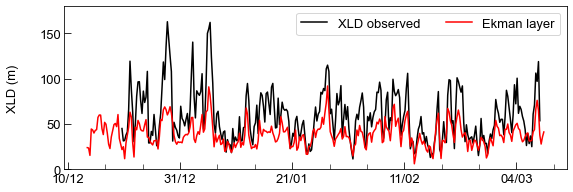

In [56]:
# change the font size
font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 13}

matplotlib.rc('font', **font)

fig,ax = subplots(figsize=(9,3))

ax.plot(dat_pfz_interp.time, dat_pfz_interp.xld,   c='k', label='XLD observed')
ax.plot(dat_pfz_interp.time, dat_pfz_interp.h_ek,  c='r', label='Ekman layer')

ax.set_ylim(0, 180)

ax.xaxis.set_major_locator(weeks)
ax.xaxis.set_minor_locator(week)
ax.xaxis.set_major_formatter(yearsFmt)

ax.set_ylabel('XLD (m)', labelpad=20)
ax.legend(ncol=2, loc=1)

savefig('../figures/XLD_observed_ekman_layer.png', dpi=300, bbox_inches='tight')

What is the RMSE between the XLD and the ekman layer?

In [57]:
np.corrcoef(dat_pfz_interp.xld[dat_pfz_interp.xld>0], dat_pfz_interp.h_ek[dat_pfz_interp.xld>0])

array([[1.        , 0.83317973],
       [0.83317973, 1.        ]])

In [58]:
np.sqrt((dat_pfz_interp.xld - dat_pfz_interp.h_ek)**2).mean()

<xarray.DataArray ()>
array(20.92658086)

Calculate the mixing layer regression

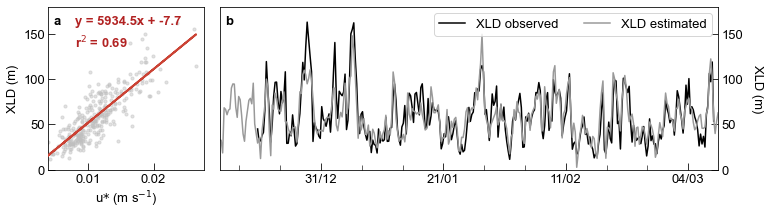

In [59]:
### MIXING LAYER DEPTH REGRESSION

# setting the plot
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12,3))
gs = gridspec.GridSpec(nrows=1,ncols=4, wspace=0.1)  # sets a grid of 1 rows by 4 column

# mixing layer u-star regression

ax = fig.add_subplot(gs[0, 0]) # this says first 3 grid points in rows, and 2 columns i.e., (a)

ax.scatter(dat.u_star, dat.xld, c='0.75', alpha=0.45, s=10)

ax.set_xlim(0.004)
ax.set_ylim(0, 180)

X = dat['u_star'].values
Y = dat['xld'].values

i_good=~np.isnan(Y) # find the good data
X = X[i_good]; Y = Y[i_good]

X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

ax.plot(X, Y_pred, c=red, lw=2, zorder=10)

# get the slope and intercept
slope     = np.round(linear_regressor.coef_.squeeze(), 1)
intercept = np.round(linear_regressor.intercept_.squeeze(), 1)

ax.text(0.008, 160, 'y = '+str(slope)+'x + ' + str(intercept), fontweight='bold', c='firebrick')

# correlation
corr = np.round(linear_regressor.score(X, Y), 2)  # perform linear regression
ax.text(0.008, 135, 'r$^2$ = ' + str(corr), fontweight='bold', c='firebrick')

ax.set_xlabel('u$*$ (m s$^{-1}$)')
ax.set_ylabel('XLD (m)')

ax.text(0.0047, 160, 'a', fontweight='bold')

# mixing layer observed vs estimated
ax = fig.add_subplot(gs[0, 1:4]) # this says first 3 grid points in rows, and 2 columns i.e., (a)

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

ax.plot(dat_pfz_interp.time, dat_pfz_interp.xld, c='k', label='XLD observed')
ax.plot(dat_pfz_interp.time, slope*dat_pfz_interp['u_star']+intercept, c='0.6', label='XLD estimated')

ax.set_ylim(0, 180)

ax.xaxis.set_major_locator(weeks)
ax.xaxis.set_minor_locator(week)
ax.xaxis.set_major_formatter(yearsFmt)

ax.set_ylabel('XLD (m)', rotation=-90, labelpad=20)
ax.legend(ncol=2, loc=1)

ax.text(dat_pfz_interp.time.values[4], 160, 'b', fontweight='bold')

ax.set_xlim(dat_pfz_interp.time.values[0], dat_pfz_interp.time.values[-1])

savefig('../figures/XLD_observed_estimated.png', dpi=300, bbox_inches='tight')

#### Determine the estimated mixing depth for all sites

In [60]:
for dat in [dat_saz_interp, dat_pfz_interp, dat_miz_interp]:
    
    dat['u_star'] = (('time'), sqrt(dat['tau']/1027)) # frictional velocity
    dat['xld_est'] = slope*dat['u_star']+intercept    # estimated mixing depth

Plot H_prt and H_ek for all the sites compared to the mixed layer 

In [61]:
dat_saz_1D = dat_saz_interp.resample(time='1D', loffset='12H').mean()
dat_pfz_1D = dat_pfz_interp.resample(time='1D', loffset='12H').mean()
dat_miz_1D = dat_miz_interp.resample(time='1D', loffset='12H').mean()

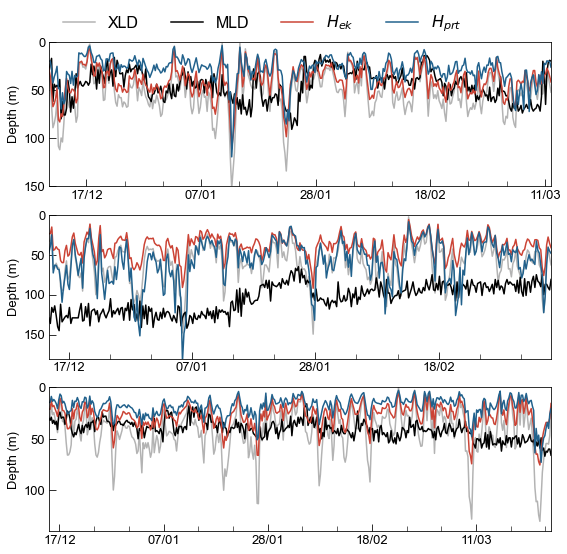

In [63]:
fig,ax=subplots(3, figsize=[9,9]) 

for i, dat in enumerate([dat_saz_interp, dat_pfz_interp, dat_miz_interp]):

    ax[i].plot(dat.time, dat.xld_est, c='0.7', label='XLD')
    ax[i].plot(dat.time, dat.mld_03,  c='k',   label='MLD')
    ax[i].plot(dat.time, dat.h_ek,    c=red,   label='$H_{ek}$')
    ax[i].plot(dat.time, dat.h_prt,   c=blue,  label='$H_{prt}$')
    
    ax[i].set_ylabel('Depth (m)')
    
    ax[i].set_xlim(dat.time.values[0], dat.time.values[-1])
    
    ax[i].xaxis.set_major_locator(weeks)
    ax[i].xaxis.set_minor_locator(week)
    ax[i].xaxis.set_major_formatter(yearsFmt)
    
ax[0].set_ylim(150, 0)
ax[1].set_ylim(180, 0)
ax[2].set_ylim(140, 0)

ax[0].legend(loc=2, bbox_to_anchor=(0, 1.3), fontsize=16, frameon=False, ncol=4)

savefig('../figures/Final Figures/Fig_S1_xld_hek_hprt_mld.png', dpi=300)

### Rossby radius of deformation length scale

In [64]:
for dat in [dat_saz_interp, dat_pfz_interp, dat_miz_interp]:
    
    n = []
    
    for i, m in enumerate(np.round(dat['mld_03'].astype(int))):
        
        n += np.sqrt(dat.N2.sel(depth=slice(5, m+10)).mean(dim='depth').values[i]),
        
    Lf = np.nanmean((n * dat.mld_03) / gsw.f(dat.lat))
    
#     print(np.nanmean(n))
    
    print(Lf)

-2094.871875443253
-2056.76509040972
-1929.6029694234262


### Figure 6
---

Glider sections of stratification

In [65]:
for i, dat in enumerate([dat_saz_interp, dat_pfz_interp, dat_miz_interp]):
    dat['pot_den'] = gsw.pot_rho_t_exact(dat.salt, dat.temp, dat.depth/1000, 10.1325)

<ipython-input-66-d994d6fc4ff0>:37: UserWarning: No contour levels were found within the data range.
  ax[i].contour(dat.time.values, dat.depth, dat.pot_den.T, levels=[1027.3], colors=red, linewidths=2)


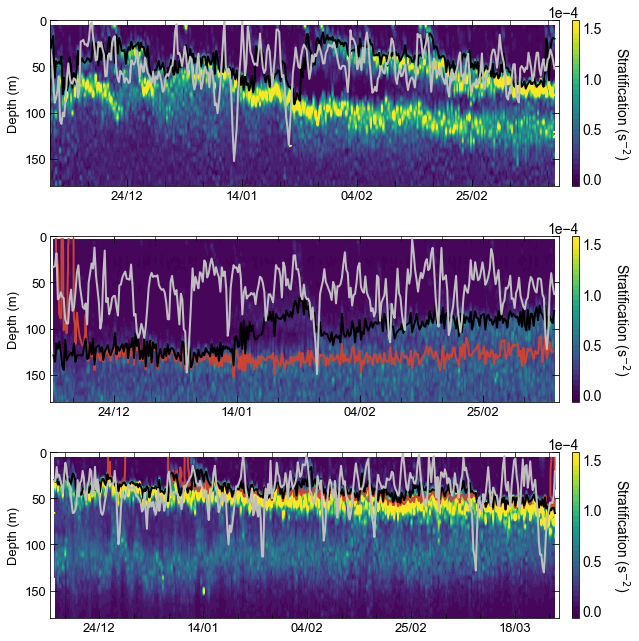

In [66]:
fig, ax = subplots(3, 1, figsize=[11,11])
fig.subplots_adjust(hspace=0.3)

# change the font size
font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 14}

matplotlib.rc('font', **font)

for i, dat in enumerate([dat_saz_interp, dat_pfz_interp, dat_miz_interp]):
    
    im=ax[i].contourf(dat.time.values, dat.depth, dat.N2.T, levels=np.arange(0, 1.55e-4, 0.5e-5), extend='both')
    cb=colorbar(mappable=im, ax=ax[i], pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(0, 4e-4, 0.5e-4))
    cb.ax.tick_params(width=0)
    cb.formatter.set_powerlimits((0, 0))
    cb.update_ticks()
    
    ax[i].xaxis.set_major_locator(weeks)
    ax[i].xaxis.set_minor_locator(week)
    ax[i].xaxis.set_major_formatter(yearsFmt)
    
    ax[i].plot(dat.time, rolling_mean(dat.mld_03,   window=1), c='k',   lw=2)
    ax[i].plot(dat.time, rolling_mean(dat.xld_est , window=1), c='0.75',lw=2)
    
#     ax[i].contour(dat.time.values, dat.depth, dat.density.T, levels=np.arange(1026, 1029, 0.1), colors='0.75', linewidths=1, alpha=0.75)
    
    ax[i].set_ylim(180, 0)
    ax[i].set_ylabel('Depth (m)', labelpad=5)
    ax[i].set_xlabel('', labelpad=5)
    
    cb.set_label('Stratification (s$^{-2}$)', rotation=-90, labelpad=30)
    
    ax[i].yaxis.set_ticks_position('both')
    ax[i].xaxis.set_ticks_position('both')
    
    ax[i].contour(dat.time.values, dat.depth, dat.pot_den.T, levels=[1027.3], colors=red, linewidths=2)
    
ax[0].set_xlim(pd.to_datetime('2018-12-10'), pd.to_datetime('2019-03-13'))
ax[1].set_xlim(pd.to_datetime('2018-12-13'), pd.to_datetime('2019-03-10'))
ax[2].set_xlim(pd.to_datetime('2018-12-14'), pd.to_datetime('2019-03-27'))

# ax[0].text(pd.to_datetime('2018-12-11'), -5, 'a', fontweight='bold')
# ax[1].text(pd.to_datetime('2018-12-14'), -5, 'b', fontweight='bold')
# ax[2].text(pd.to_datetime('2018-12-15'), -5, 'c', fontweight='bold')

# ax[0].text(dat_saz_interp.time.values[20], 150, 'XLD', color=red, fontsize=16, fontweight='bold')
# ax[0].text(dat_saz_interp.time.values[55], 150, 'MLD', color='k', fontsize=16, fontweight='bold')
    
savefig('../figures/fig6_N2_glider_sections.png', dpi=300, bbox_inches='tight')

### Figure 7 & 8: Mixed layer temperature and salinity budgets 
---

#### Load the air-sea heat and freshwater fluxes

Mixed layer budget analysis

#### 1. Air-sea heat and freshwater fluxes

In this section, we plot the impacts of heat and freshwater fluxes. The first step is to calculate the heat and freshwater fluxes using the budget equation. We assume that the heat and freshwater is being distributed within the wind-driven turbulent layer of the ocean.

But first, let's assign the heat and freshwater budget equations:

In [68]:
def heatflux(Q, mld, rho=1027, Cp=3850):
    
    return (Q / (rho * Cp * mld)) # units of C/s

def freshwaterflux(E, P, mld, S):
    
    return (( (E-P) * S ) / mld) # units psu/s

Now let's do the calculation

In [69]:
for dat in [dat_saz_interp, dat_pfz_interp, dat_miz_interp]:
    
    dat['ml_s_smooth'] = dat['ml_s_smooth'].bfill(dim='time').ffill(dim='time')
    dat['ml_t_smooth'] = dat['ml_t_smooth'].bfill(dim='time').ffill(dim='time')
    
    Q   = dat['qnet']
    mld = dat['mld_03']      
    E   = dat['e']   
    P   = dat['tp']  
    S   = dat['ml_s_smooth']        
  
    dat['dT_hf']    = heatflux(Q=Q, mld=mld)      
    dat['dS_ff']    = freshwaterflux(E=E, P=P, mld=mld, S=S)

#### 2. Ekman Advection calculation

Next, we look at Ekman advection as a possible mechanism which moves gradients around

In [70]:
import scipy

def ekman_transport(dat, dt, grad, rho0=1027):

    f    = np.abs(gsw.f(dat['lat'])) # coriolis s-1
    taux = dat['taux']               # wind stress
    h    = dat['xld_est']            # mixing layer depth
    u10  = dat['u10']                # u-component of the wind
    
    taux[u10<0] = -taux[u10<0]       # make the u-wind stress negative when the wind is blowing westward
    
    dat['ek_vel_v'] = taux / (rho0 * h * f) # caluclate ekman velocity in units of m s-1
    
    dat['ek_trans_dS'] =  (( dat['ek_vel_v'] * dat['dS_'+grad].values)) # mutiply the ekman anomaly (m) to the gradients (g kg-1 m-1) to get g kg-1
    dat['ek_trans_dT'] =  (( dat['ek_vel_v'] * dat['dT_'+grad].values)) # degC
    
    return dat

Now do the calculations

In [71]:
from scipy import integrate

for dat in [dat_saz_interp, dat_pfz_interp]:
        
    dat = ekman_transport(dat, dt=86400, grad='tsg')
    
dat_miz_interp = ekman_transport(dat_miz_interp, dt=86400, grad='grad')

#### 3. Entrainment

In [72]:
def entrainment(dat, mld, xld, dt):
    
    mld = gt.cleaning.rolling_window(mld, func=np.mean, window=4) # smoothing window over mld
    xld = gt.cleaning.rolling_window(xld, func=np.mean, window=4) # smoothing window over xld
    
    d_mld = xld-mld # difference between xld and mld
    dh    = np.append(np.array(0), np.diff(mld)).astype(int) # rate of xld deepening in units m, positive = deepening
    
    we = dh/dt    # entrainment velocity is the rate of xld deepening in m/s
    we[we<0]=0    # if the entrainment vel is negative, there is no entrainment
    we[d_mld<0]=0 # if the entrainment vel is negative, there is no entrainment
    
    xld = xld.astype(int).values # make the xld and mld integers
    mld = mld.astype(int).values # make the xld and mld integers

    T_xld = [np.mean([dat.temp.values[i, val], dat.temp.values[i, mld[i]]]) for i, val in enumerate(xld)] # get the mean temperature between the xld and mld
    S_xld = [np.mean([dat.salt.values[i, val], dat.salt.values[i, mld[i]]]) for i, val in enumerate(xld)] # get the mean salinity between the xld and mld

    S_mld = [dat.salt.values[i, val] for i, val in enumerate(mld)] # get the salinity at the mld
    T_mld = [dat.temp.values[i, val] for i, val in enumerate(mld)] # get the temperature at the mld
    
    S_mld_15m = [dat.salt.values[i, val+15] for i, val in enumerate(mld)] # get the salinity 5m below the mld
    T_mld_15m = [dat.temp.values[i, val+15] for i, val in enumerate(mld)] # get the temperature 5m below the mld
    
    S_xld=np.array(S_xld)
    S_mld=np.array(S_mld)
    
    T_xld=np.array(T_xld)
    T_mld=np.array(T_mld)
    
    ent_S = (we*(S_mld_15m - S_mld))/xld 
    ent_T = (we*(T_mld_15m - T_mld))/xld
    
    dat['ent_dS'] = (('time'), ent_S)
    dat['ent_dT'] = (('time'), ent_T)
    
    return dat

In [73]:
for dat in [dat_saz_interp, dat_pfz_interp, dat_miz_interp]:
        
    dat = entrainment(dat=dat, mld=dat['mld_03'], xld=dat['xld_est'], dt=21600)

### Figure 7: mixed layer temperature tendency
---

In [74]:
dat_saz_1D = dat_saz_interp.resample(time='1D', loffset='12H').mean()
dat_pfz_1D = dat_pfz_interp.resample(time='1D', loffset='12H').mean()
dat_miz_1D = dat_miz_interp.resample(time='1D', loffset='12H').mean()

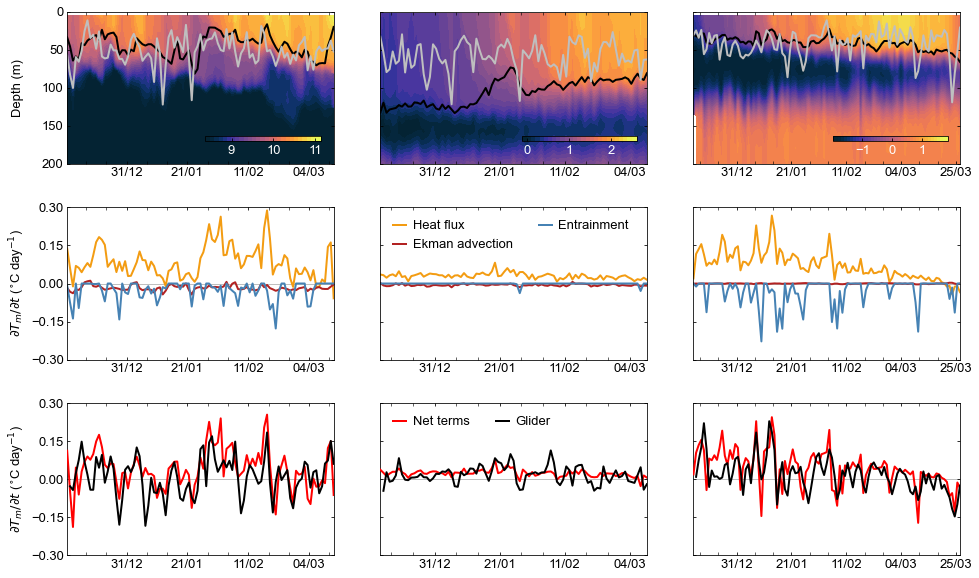

In [78]:
# change the font size
font = {'family' : 'Arial',
        'weight' : 'ultralight',
        'size'   : 13}

matplotlib.rc('font', **font)

rc('ytick.major', size=3)
rc('xtick.major', size=3)
rc('ytick.minor', size=3)
rc('xtick.minor', size=3)

# set the plot
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16,10))

gs = gridspec.GridSpec(nrows=9,ncols=3)  # sets a grid of 6 rows by 4 column

fig.subplots_adjust(hspace=2, wspace=0.175)

props=dict(fontsize=12)

for i, dat in enumerate([dat_saz_1D, dat_pfz_1D, dat_miz_1D]):

    # plotting the mixed layer sections
    
    ax1 = fig.add_subplot(gs[0:3, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)
    
    vmins = [8.5,0, -1.8]
    vmaxs = [11, 2.5, 1.7]
    
    h1=ax1.contourf(dat.time.values, dat.depth, dat.temp.T, levels=np.arange(vmins[i], vmaxs[i]+0.1, 0.1), cmap=cmo.thermal, extend='both')
    
    ax1.plot(dat.time, dat.mld_03 , c='k',    lw=2)
    ax1.plot(dat.time, dat.xld_est, c='0.75', lw=2)
    
    ax1.xaxis.set_ticklabels([])
        
    ################################
    # plotting the tendency sections
    ################################
    
    ax2 = fig.add_subplot(gs[3:6, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)
    
    dat['hf_dT'] = dat['dT_hf']      *86400
    dat['ek_dT'] = dat['ek_trans_dT']*86400
    dat['en_dT'] = dat['ent_dT']     *86400
    
    
    ax2.plot(dat.time, dat['hf_dT'], c=orange,        lw=2, label='Heat flux')
    ax2.plot(dat.time, dat['ek_dT'], c='firebrick',   lw=2, label='Ekman advection')
    ax2.plot(dat.time, dat['en_dT'], c='steelblue',   lw=2, label='Entrainment')
        
    ################################
    # plotting the tendency sections
    ################################
    
    ax3 = fig.add_subplot(gs[6:9, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)        

    dat['net_terms_dT'] = dat['hf_dT'] + dat['ek_dT'] + dat['en_dT'] 
    dat['glider_dT']    = dat['ml_t_smooth'].diff(dim='time')
    
    ax3.plot(dat.time    , dat['net_terms_dT']    , label='Net terms', c='r', lw=2, zorder=10) 
    ax3.plot(dat.time[1:], dat['glider_dT'][1:],    label='Glider',    c='k', lw=2, zorder=10)     
        
    ################################
    # plotting edits
    ################################
    
    if i==0:
        ax1.set_ylabel('Depth (m)', labelpad=18)
        ax2.set_ylabel( r'$\partial T_m / \partial t$ ($^{\circ}$C day$^{-1}$)')
        ax3.set_ylabel( r'$\partial T_m / \partial t$ ($^{\circ}$C day$^{-1}$)')
        
    if i>0:
        for a in [ax1, ax2, ax3]:
            a.yaxis.set_ticklabels([])

    for a in [ax1, ax2, ax3]:
        
        a.xaxis.set_major_locator(weeks)
        a.xaxis.set_minor_locator(week)
        a.xaxis.set_major_formatter(yearsFmt)
        
        a.yaxis.set_ticks_position('both')
        a.xaxis.set_ticks_position('both')
                
    ax1.set_xlim(dat.time.values[0], dat.time.values[-1])
    ax2.set_xlim(dat.time.values[0], dat.time.values[-1])
    ax3.set_xlim(dat.time.values[0], dat.time.values[-1])
        
    ax1.yaxis.set_ticks([0, 50, 100, 150, 200])
    
    # legend 
    
    if i==1:
        ax1.set_ylim(200, 0)
        ax2.legend(ncol=2, loc=2, handlelength=1, handletextpad=0.5, borderpad=0.5, fontsize=13, frameon=False)
        ax3.legend(ncol=2, loc=2, handlelength=1, handletextpad=0.5, borderpad=0.5, fontsize=13, frameon=False)
    else:
        ax1.set_ylim(200, 0)
    
    # colorbars 
    
    if i==0:
        cax = fig.add_axes(([0.245, 0.7, 0.1, 0.0075]))
        cb = colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(-2, 12.5, 1.0), orientation='horizontal')
        cb = plt.getp(cb.ax.axes, 'xticklabels') 
        plt.setp(cb, color='w')
        
    if i==1:
        cax = fig.add_axes(([0.52, 0.7, 0.1, 0.0075]))
        cb = colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(-2, 12.5, 1.0), orientation='horizontal')
        cb = plt.getp(cb.ax.axes, 'xticklabels') 
        plt.setp(cb, color='w')
        
    if i==2:
        cax = fig.add_axes(([0.79, 0.7, 0.1, 0.0075]))
        cb = colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(-2, 12.5, 1.0), orientation='horizontal')
        cb = plt.getp(cb.ax.axes, 'xticklabels') 
        plt.setp(cb, color='w')
        
    ax2.set_ylim(-0.3, 0.3)
    ax3.set_ylim(-0.3, 0.3)
    
    ax2.yaxis.set_ticks(np.arange(-0.3, 0.45, 0.15))
    ax3.yaxis.set_ticks(np.arange(-0.3, 0.45, 0.15))
    
    ax2.plot([pd.to_datetime('2018-12-10'), pd.to_datetime('2019-03-26')], [0, 0], zorder=0, lw=1, c='0.75')
    ax3.plot([pd.to_datetime('2018-12-10'), pd.to_datetime('2019-03-26')], [0, 0], zorder=0, lw=1, c='0.75')
    

savefig('../figures/Fig_7_temp_tendency_breakdown.png', dpi=300, bbox_inches='tight')

### Figure 8: mixed layer salinity tendency
---

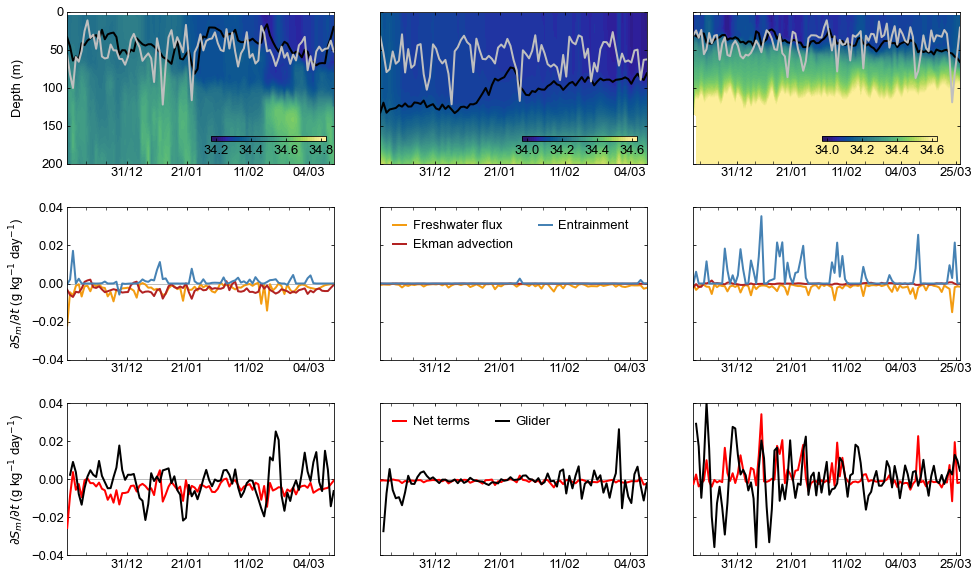

In [83]:
# set the plot
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16,10))

gs = gridspec.GridSpec(nrows=9,ncols=3)  # sets a grid of 6 rows by 4 column

fig.subplots_adjust(hspace=2, wspace=0.175)

props=dict(fontsize=12)

for i, dat in enumerate([dat_saz_1D, dat_pfz_1D, dat_miz_1D]):

    # plotting the mixed layer sections
    
    ax1 = fig.add_subplot(gs[0:3, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)
    
    vmins = [34.2, 34, 34]
    vmaxs = [34.8, 34.6, 34.6]
    
    h1=ax1.contourf(dat.time.values, dat.depth, dat.salt.T, levels=np.arange(vmins[i], vmaxs[i]+0.01, 0.01), cmap=cmo.haline, extend='both')
    
    ax1.plot(dat.time, dat.mld_03 , c='k',    lw=2)
    ax1.plot(dat.time, dat.xld_est, c='0.75', lw=2)
        
    ################################
    # plotting the tendency sections
    ################################
    
    ax2 = fig.add_subplot(gs[3:6, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)

    dat['ff_dS'] = dat['dS_ff']       *86400
    dat['ek_dS'] = dat['ek_trans_dS'] *86400
    dat['en_dS'] = dat['ent_dS']      *86400
  
    ax2.plot(dat.time, dat['ff_dS'], c=orange,        lw=2, label='Freshwater flux')
    ax2.plot(dat.time, dat['ek_dS'], c='firebrick',   lw=2, label='Ekman advection')
    ax2.plot(dat.time, dat['en_dS'], c='steelblue',   lw=2, label='Entrainment')
#     ax2.plot(dat.time, dat['ga_dS'], c=green,  lw=1.25, label='Geo advection')
        
    ################################
    # plotting the tendency sections
    ################################
    
    ax3 = fig.add_subplot(gs[6:9, i]) # this says first 3 grid points in rows, and 2 columns i.e., (a)        

    dat['net_terms_dS'] = dat['ff_dS'] + dat['ek_dS'] + dat['en_dS'] 
    dat['glider_dS']    = dat['ml_s_smooth'].diff(dim='time')
    
    ax3.plot(dat.time    , dat['net_terms_dS'], label='Net terms',  c='r', lw=2, zorder=10) 
    ax3.plot(dat.time[1:], dat['glider_dS'][1:], label='Glider',    c='k', lw=2, zorder=10)        
        
    ################################
    # plotting edits
    ################################
    
    if i==0:
        ax1.set_ylabel('Depth (m)', labelpad=18)
        ax2.set_ylabel( r'$\partial S_m / \partial t$ (g kg$^{-1}$ day$^{-1}$)')
        ax3.set_ylabel( r'$\partial S_m / \partial t$ (g kg$^{-1}$ day$^{-1}$)')
        
    if i>0:
        for a in [ax1, ax2, ax3]:
            a.yaxis.set_ticklabels([])

    for a in [ax1, ax2, ax3]:
        
        a.xaxis.set_major_locator(weeks)
        a.xaxis.set_minor_locator(week)
        a.xaxis.set_major_formatter(yearsFmt)
        
        a.yaxis.set_ticks_position('both')
        a.xaxis.set_ticks_position('both')
        
#         a.grid(lw=0.5, alpha=0.5, ls='--')
        
    ax1.set_xlim(dat.time.values[0], dat.time.values[-1])
    ax2.set_xlim(dat.time.values[0], dat.time.values[-1])
    ax3.set_xlim(dat.time.values[0], dat.time.values[-1])
        
    ax1.yaxis.set_ticks([0, 50, 100, 150, 200])
    
    # legend 
    
    if i==1:
        ax1.set_ylim(200, 0)
        ax2.legend(ncol=2, loc=2, handlelength=1, handletextpad=0.5, borderpad=0.5, fontsize=13, frameon=False)
        ax3.legend(ncol=2, loc=2, handlelength=1, handletextpad=0.5, borderpad=0.5, fontsize=13, frameon=False)
    else:
        ax1.set_ylim(200, 0)
    
    # colorbars 
    
    if i==0:
        cax = fig.add_axes(([0.25, 0.7, 0.1, 0.0075]))
        cb = colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(34, 35.2, 0.2), orientation='horizontal')
        
    if i==1:
        cax = fig.add_axes(([0.52, 0.7, 0.1, 0.0075]))
        cb = colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(34, 35.2, 0.2), orientation='horizontal')
        
    if i==2:
        cax = fig.add_axes(([0.78, 0.7, 0.1, 0.0075]))
        cb = colorbar(mappable=h1, cax=cax, pad=0.02, extendrect=True, drawedges=False, ticks=np.arange(34, 35.2, 0.2), orientation='horizontal')
        
    ax2.set_ylim(-0.04, 0.04)
    ax3.set_ylim(-0.04, 0.04)
    
#     ax2.yaxis.set_ticks(np.arange(-0.3, 0.45, 0.15))
#     ax3.yaxis.set_ticks(np.arange(-0.3, 0.45, 0.15))
    
    ax2.plot([pd.to_datetime('2018-12-10'), pd.to_datetime('2019-03-26')], [0, 0], zorder=0, lw=1, c='0.75')
    ax3.plot([pd.to_datetime('2018-12-10'), pd.to_datetime('2019-03-26')], [0, 0], zorder=0, lw=1, c='0.75')
    

savefig('../figures/Fig_8_salt_tendency_breakdown.png', dpi=300, bbox_inches='tight')

7.663189832985128e-05
3.61092278850166e-05
0.00016077424006653344


1.113528638094834e-05
7.884305749834285e-07
5.148019828091615e-05


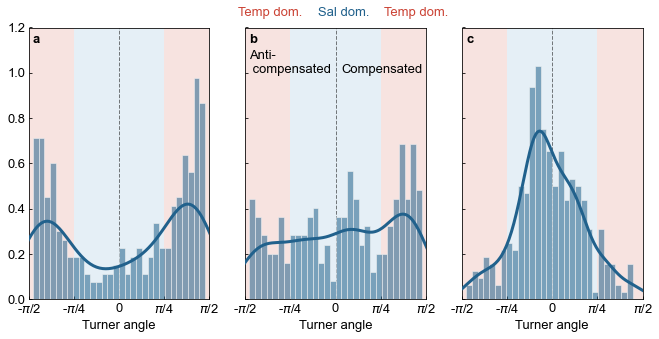

## Mixed layer eddy calculations and pie charts

We determine the mixed layer buoyancy from the average buoyancy across the mixed layer.

In [87]:
# get the mean buoyancy within the mixed layer
for dat in [dat_saz_1D, dat_pfz_1D, dat_miz_1D]:

    xb=[]
    
    for i, m in enumerate(np.round(dat['mld_03'].astype(int))):
        
        xb += dat.buoyancy.sel(depth=slice(5, m-5)).mean(dim='depth').values[i],
    
    dat['ml_b'] = (('time'), xb)

Determine the lateral buoyancy bouyancy gradient from the interpolated values of buoyancy to a common grid. The grid used here is 2 km. 

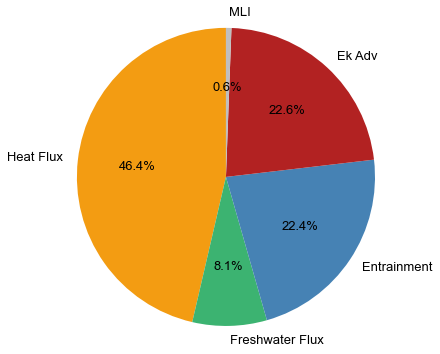

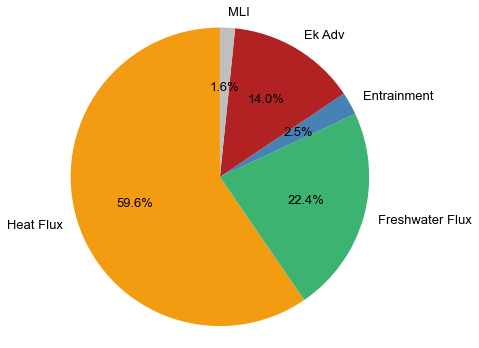

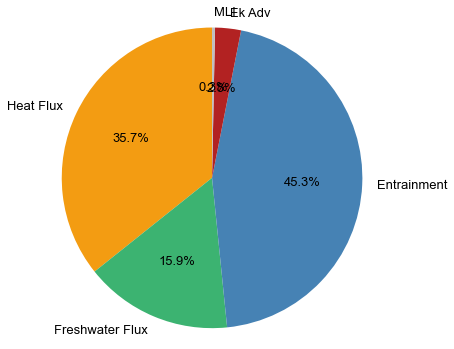

In [89]:
sites = ['saz', 'pfz', 'miz']

for i, dat in enumerate([dat_saz_1D, dat_pfz_1D, dat_miz_1D]):
    
    if i==0:
        dat_raw=dat_saz
    if i==1:
        dat_raw=dat_pfz
    if i==2:
        dat_raw=dat_miz
        
    dat_raw['buoyancy'] = -9.81*(dat_raw['density']-1025)/1025
        
    xb=[]
    xt=[]
    xs=[]
    
    for c, m in enumerate(np.round(dat_raw['mld_03'].astype(int))):
        
        xb += dat_raw.buoyancy.sel(depth=slice(10, m-5)).mean(dim='depth').values[c],        
        xt += dat_raw.temp.sel(depth=slice(10, m-5)).mean(dim='depth').values[c],
        xs += dat_raw.salt.sel(depth=slice(10, m-5)).mean(dim='depth').values[c],
    
    dat_raw['ml_s'] = (('time'), xs)
    dat_raw['ml_t'] = (('time'), xt)
    dat_raw['ml_b'] = (('time'), xb)
    
    for c, val in enumerate(dat_raw.ml_b):
            
        if val<-0.027:
            dat_raw['ml_b'][c] = dat_raw['ml_b'][c-1] 
        
    # determin the along-track distance 
    d = gsw.distance(dat_raw.lon.values, dat_raw.lat.values)
    d_sum = np.append(0, np.cumsum(d))
    
    # make a new grid from cumulative sum of the distances
    new_grid = np.arange(0, d_sum[-1], 6000)
    
    t = date2num(dat_raw.time.values)
    
    # interpolate the mixed layer buoyancy and depth to the new grid
    ml_b_6km = scipy.interpolate.griddata(d_sum, dat_raw['ml_b'].values,   new_grid)
    mld_6km  = scipy.interpolate.griddata(d_sum, dat_raw['mld_03'].values, new_grid)
    time_6km = scipy.interpolate.griddata(d_sum, t,                        new_grid)
    
    # find the buoyancy gradients
    ml_bx_6km = np.diff(ml_b_6km)/6000
    
    # Submesoscale MLI equivalent heat flux
    
    #set the parameters for the equivalent heat flux equation
    
    c     = 0.06         # emperically defined coefficient
    bx    = ml_bx_6km    # buoyancy gradient
    H     = mld_6km[1:]  # mixed layer depth
    f     = gsw.f(dat_raw.lat).mean().values # coriolis freq
    Cp    = 3850         # specific heat capacity
    rho0  = 1027         # density
    alpha = gsw.alpha(dat_raw.ml_s, dat_raw.ml_t, 0).mean().values # thermal expansion coeff
    g     = 9.81         # gravitational acceleration
    
    # determine the MLI flux
    
    mli = c * ( (bx**2 * H**2)/np.abs(f) ) * ( (Cp*rho0)/(alpha*g) )
    
    dat_raw['mli'] = (('time'), scipy.interpolate.griddata(time_6km[:-1], mli, t))
    
    ###################
    
    # convert the tendency units of C/s and psu/s to W m-2
    
    hm     = dat['mld_03'] # mixed layer depth
    beta   = -gsw.beta(dat.ml_s_smooth, dat.ml_t_smooth, 0).mean() # haline contraction coeff
    alpha  = gsw.alpha(dat.ml_s_smooth, dat.ml_t_smooth, 0).mean() # haline contraction coeff

    dat['hf_wm2']   = dat['dT_hf']       * (rho0*Cp*hm) # heat flux
    dat['en_t_wm2'] = dat['ent_dT']      * (rho0*Cp*hm) # entrainment
    dat['ek_t_wm2'] = dat['ek_trans_dT'] * (rho0*Cp*hm) # ekman adv
    
    dat['ff_wm2']   = dat['dS_ff']       * (rho0*Cp*hm*(beta/alpha)) # freshwater flux
    dat['ek_s_wm2'] = dat['ek_trans_dS'] * (rho0*Cp*hm*(beta/alpha)) # entrainment
    dat['en_s_wm2'] = dat['ent_dS']      * (rho0*Cp*hm*(beta/alpha)) # ekman adv
    
    dat['mli_wm2']  = dat_raw['mli'].interp_like(dat)
    
    # now plot the pie chart
    
    labels = 'Heat Flux', 'Freshwater Flux', 'Entrainment', 'Ek Adv', 'MLI'
    clrs   = orange, 'mediumseagreen', 'steelblue', 'firebrick', '0.75'
    
    hf   = np.nanmean(np.abs(dat['hf_wm2']))
    ff   = np.nanmean(np.abs(dat['ff_wm2']))
    
    en = np.nanmean(np.abs(dat['en_t_wm2']) + np.abs(dat['en_s_wm2']))
    ek = np.nanmean(np.abs(dat['ek_t_wm2']) + np.abs(dat['ek_s_wm2']))
    
    sm   = np.nanmean(np.abs(dat['mli_wm2']))
    
    total = hf+ff+en+ek+sm   
    
    sizes = [hf/total, ff/total, en/total, ek/total, sm/total]
    
    fig,ax=subplots(figsize=[6,6])
    
    ax.pie(sizes, 
           labels=labels, 
           autopct='%1.1f%%', 
           colors=clrs,
           startangle=90)
    
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
#     ax.legend(ncol=6, bbox_to_anchor=(0, 1))
    
    savefig('../figures/Fig_10_pie_'+str(sites[i])+'_labels.png', dpi=300, bbox_inches='tight')

#### Conversion of tendency units to W m-2

What are the equivalent heat flux mean contributions for each term?

In [90]:
for i, dat in enumerate([dat_saz_1D, dat_pfz_1D, dat_miz_1D]):
    
    print('-----')
    
    print('heat flux: ' + str(np.round(np.nanmean(dat['hf_wm2'] .values))) + ' std ' + str(np.round(np.nanstd(dat['hf_wm2'] .values))))
    print('fresh flx: ' + str(np.round(np.nanmean(dat['ff_wm2'] .values))) + ' std ' + str(np.round(np.nanstd(dat['ff_wm2'] .values))))
    print('sms mli  : ' + str(np.round(np.nanmean(dat['mli_wm2'].values))) + ' std ' + str(np.round(np.nanstd(dat['mli_wm2'].values))))
    
    en = dat['en_t_wm2'] + dat['en_s_wm2'] # substract the salinity equiv. W m-2 from the temperature as neg salinity means freshening
    ek = dat['ek_t_wm2'] + dat['ek_s_wm2'] # substract the salinity equiv. W m-2 from the temperature as neg salinity means freshening
    
    print('entrainmt: ' + str(np.round(np.nanmean(en.values))) + ' std ' + str(np.round(np.nanstd(en.values))))
    print('ekmanadvn: ' + str(np.round(np.nanmean(ek.values))) + ' std ' + str(np.round(np.nanstd(ek.values))))

-----
heat flux: 140.0 std 81.0
fresh flx: 25.0 std 26.0
sms mli  : 2.0 std 6.0
entrainmt: -68.0 std 110.0
ekmanadvn: -6.0 std 5.0
-----
heat flux: 146.0 std 57.0
fresh flx: 55.0 std 41.0
sms mli  : 4.0 std 7.0
entrainmt: -6.0 std 39.0
ekmanadvn: -25.0 std 17.0
-----
heat flux: 118.0 std 77.0
fresh flx: 55.0 std 63.0
sms mli  : 1.0 std 2.0
entrainmt: -158.0 std 290.0
ekmanadvn: 3.0 std 9.0
